In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1
!pip install gym[classic_control]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.5/821.5 kB 14.9 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 47.5 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.5.2
    Uninstalling pygame-2.5.2:
      Successfully uninstalled pygame-2.5.2


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gym
from gym.wrappers.record_video import RecordVideo
import glob
import io
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
from pyvirtualdisplay import Display
import tensorflow as tf
from IPython import display as ipythondisplay
from PIL import Image
import tensorflow_probability as tfp

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <


In [ ]:
'''
Bunch of Hyper parameters (Which you might have to tune later)
'''
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
LR = 5e-5             # learning rate
UPDATE_EVERY = 20       # how often to update the network (When Q target is present)

env = gym.make('CartPole-v1')
state = env.reset()
print(state)

[ 0.01488718 -0.03706156 -0.03969997  0.02440084]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
class QNetwork1(nn.Module):

  def __init__(self, state_size, action_size, hl_size):
    super(QNetwork1,self).__init__()
    self.input_layer = nn.Linear(state_size,hl_size)
    self.value_layer = nn.Linear(hl_size,1)
    self.advantage_layer = nn.Linear(hl_size,action_size)

  def forward(self,state):
    x = F.relu(self.input_layer(state))
    value = self.value_layer(x)
    advantage = self.advantage_layer(x)
    return value , advantage


network = QNetwork1(2,2,2)
print(network.forward(torch.tensor([[1,4],[1,4]],dtype=torch.float32)))

(tensor([[-0.5581],
        [-0.5581]], grad_fn=<AddmmBackward0>), tensor([[-0.2740, -0.1630],
        [-0.2740, -0.1630]], grad_fn=<AddmmBackward0>))


## Replay Buffer

In [ ]:
import random
import torch
import numpy as np
from collections import deque, namedtuple

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

#Dueling DQN

#mean(A)

In [ ]:
class TutorialAgent():

    def __init__(self, state_size, action_size, seed):

        ''' Agent Environment Interaction '''
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        ''' Q-Network '''
        self.qnetwork_local = QNetwork1(state_size, action_size, hl_size = 42).to(device)
        self.qnetwork_target = QNetwork1(state_size, action_size, hl_size = 42).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        ''' Replay memory '''
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        ''' Initialize time step (for updating every UPDATE_EVERY steps)           -Needed for Q Targets '''
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):

        ''' Save experience in replay memory '''
        self.memory.add(state, action, reward, next_state, done)

        ''' If enough samples are available in memory, get random subset and learn '''
        if len(self.memory) >= BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

        """ +Q TARGETS PRESENT """
        ''' Updating the Network every 'UPDATE_EVERY' steps taken '''
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def act(self, state, eps=0.5):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            _,action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        ''' Epsilon-greedy action selection (Already Present) '''
        if random.random() > eps:
            return torch.argmax(action_values.to('cpu'),dim=1).item()
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """ +E EXPERIENCE REPLAY PRESENT """
        states, actions, rewards, next_states, dones = experiences
        ''' Get max predicted Q values (for next states) from target model'''
        V_targets_next, A_targets_next = self.qnetwork_target(next_states)
        Q_targets_next = torch.add(V_targets_next, A_targets_next - A_targets_next.mean(dim=1, keepdim=True)).detach().max(1)[0].unsqueeze(1)

        ''' Compute Q targets for current states '''
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        ''' Get expected Q values from local model '''
        Q_expected = torch.add(V_targets, A_targets - A_targets.mean(dim=1, keepdim=True)).gather(1, actions)

        ''' Compute loss '''
        loss = F.mse_loss(Q_expected, Q_targets)

        ''' Minimize the loss '''
        self.optimizer.zero_grad()
        loss.backward()
        ''' Gradiant Clipping '''
        """ +T TRUNCATION PRESENT """
        for param in self.qnetwork_local.parameters():
            param.grad.data.clamp_(-1, 1)

        self.optimizer.step()




In [ ]:
''' Defining DQN Algorithm '''

state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n


def dqn(n_episodes=10000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995,print_reward = False):

    scores_window = deque(maxlen=100)
    ''' last 100 scores for checking if the avg is more than 195 '''

    eps = eps_start
    ''' initialize epsilon '''
    total_reward = []
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break

        scores_window.append(score)
        total_reward.append(score)
        eps = max(eps_end, eps_decay*eps)
        ''' decrease epsilon '''

        # print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, score), end="")

        if i_episode % 100 == 0 and print_reward == True:
           print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=450.0:
           print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
           break
    return total_reward

''' Trial run to check if algorithm runs and saves the data '''

begin_time = datetime.datetime.now()

agent = TutorialAgent(state_size=state_shape,action_size = action_shape,seed = 0)
reward_arr = dqn(print_reward = True)

time_taken = datetime.datetime.now() - begin_time

print(time_taken)

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 100	Average Score: 20.38
Episode 200	Average Score: 13.54
Episode 300	Average Score: 11.44
Episode 400	Average Score: 10.23
Episode 500	Average Score: 10.09
Episode 600	Average Score: 9.81
Episode 700	Average Score: 9.64
Episode 800	Average Score: 9.59
Episode 900	Average Score: 9.63
Episode 1000	Average Score: 9.52
Episode 1100	Average Score: 9.77
Episode 1200	Average Score: 10.05
Episode 1300	Average Score: 10.81
Episode 1400	Average Score: 10.51
Episode 1500	Average Score: 9.50
Episode 1600	Average Score: 9.55
Episode 1700	Average Score: 10.16
Episode 1800	Average Score: 12.00
Episode 1900	Average Score: 12.04
Episode 2000	Average Score: 26.53
Episode 2100	Average Score: 21.06
Episode 2200	Average Score: 16.71
Episode 2300	Average Score: 15.21
Episode 2400	Average Score: 15.13
Episode 2500	Average Score: 14.73
Episode 2600	Average Score: 14.46
Episode 2700	Average Score: 14.37
Episode 2800	Average Score: 14.22
Episode 2900	Average Score: 14.19
Episode 3000	Average Score: 14.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


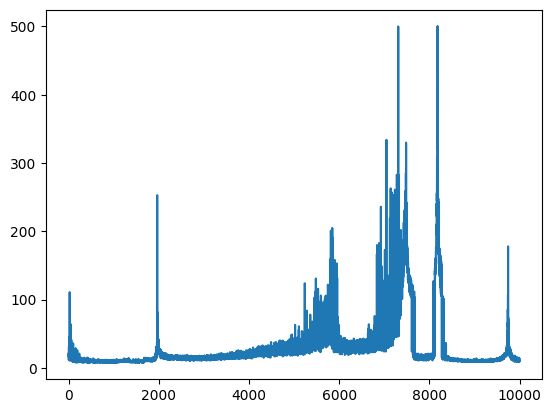

In [ ]:
plt.plot(np.arange(len(reward_arr)),reward_arr)

In [ ]:
torch.save(agent.qnetwork_local,'model.pth')

In [ ]:
N = 5
reward_avg = []
for i in range(5):
  agent = TutorialAgent(state_size=state_shape,action_size = action_shape,seed = 0)
  reward_avg.append(dqn())
  print(f'Completed {i+1} iterations')

Completed 1 iterations
Completed 2 iterations
Completed 3 iterations
Completed 4 iterations
Completed 5 iterations


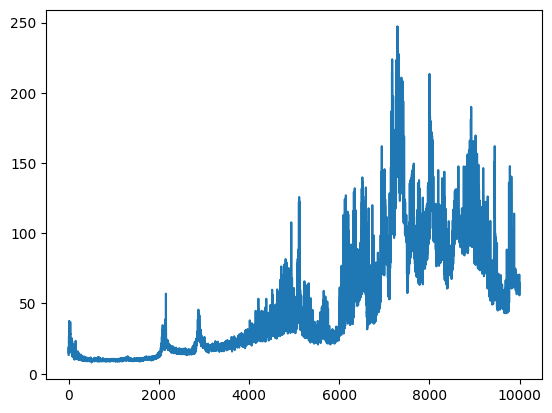

In [ ]:
# reward_avg = np.array(reward_avg)
min_size = min([len(i) for i in reward_avg ])
avg_reward = np.mean(np.array([i[:min_size] for i in reward_avg]),axis = 0)
plt.plot(np.arange(len(avg_reward)),avg_reward)
plt.show()

In [ ]:
reward_save = [i[:min_size] for i in reward_avg]
np.save("reward_CartPole_mean.npy", reward_save)

##max(A)

In [ ]:
class TutorialAgent():

    def __init__(self, state_size, action_size, seed):

        ''' Agent Environment Interaction '''
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        ''' Q-Network '''
        self.qnetwork_local = QNetwork1(state_size, action_size, hl_size = 42).to(device)
        self.qnetwork_target = QNetwork1(state_size, action_size, hl_size = 42).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        ''' Replay memory '''
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        ''' Initialize time step (for updating every UPDATE_EVERY steps)           -Needed for Q Targets '''
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):

        ''' Save experience in replay memory '''
        self.memory.add(state, action, reward, next_state, done)

        ''' If enough samples are available in memory, get random subset and learn '''
        if len(self.memory) >= BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

        """ +Q TARGETS PRESENT """
        ''' Updating the Network every 'UPDATE_EVERY' steps taken '''
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def act(self, state, eps=0.5):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            _,action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        ''' Epsilon-greedy action selection (Already Present) '''
        if random.random() > eps:
            return torch.argmax(action_values,dim=1).item()
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """ +E EXPERIENCE REPLAY PRESENT """
        states, actions, rewards, next_states, dones = experiences
        ''' Get max predicted Q values (for next states) from target model'''
        V_targets_next, A_targets_next = self.qnetwork_target(next_states)
        # V_targets_next = V_targets_next.detach().max(1)[0].unsqueeze(1)
        # A_targets_next = A_targets_next.detach().max(1)[0].unsqueeze(1)
        # V_targets_next = V_targets_next.detach().unsqueeze(1)
        # A_targets_next = A_targets_next.detach().unsqueeze(1)
        Q_targets_next = torch.add(V_targets_next, A_targets_next - torch.max(A_targets_next, dim=1).values.unsqueeze(1)).detach().max(1)[0].unsqueeze(1)

        ''' Compute Q targets for current states '''
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # print(Q_targets_next,Q_targets)
        # print(Q_targets_next.shape,Q_targets.shape)
        ''' Get expected Q values from local model '''
        V_targets, A_targets = self.qnetwork_local(states)
        # print(V_targets,A_targets)
        # V_targets = V_targets.detach().unsqueeze(1)
        # A_targets = A_targets.detach().unsqueeze(1)
        # print(states)
        # print(V_targets,A_targets)
        Q_expected = torch.add(V_targets, A_targets - torch.max(A_targets, dim=1).values.unsqueeze(1)).gather(1, actions)

        ''' Compute loss '''
        loss = F.mse_loss(Q_expected, Q_targets)

        ''' Minimize the loss '''
        self.optimizer.zero_grad()
        loss.backward()
        # if self.t_step == 0:
        #   print("Loss:- ",loss.item())
        ''' Gradiant Clipping '''
        """ +T TRUNCATION PRESENT """
        for param in self.qnetwork_local.parameters():
            param.grad.data.clamp_(-1, 1)

        self.optimizer.step()




In [ ]:
''' Defining DQN Algorithm '''

state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n


def dqn(n_episodes=10000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995,print_reward = False):

    scores_window = deque(maxlen=100)
    ''' last 100 scores for checking if the avg is more than 195 '''
    total_reward = []
    eps = eps_start
    ''' initialize epsilon '''

    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        total_reward.append(score)
        scores_window.append(score)

        eps = max(eps_end, eps_decay*eps)
        ''' decrease epsilon '''

        # print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, score), end="")

        if i_episode % 100 == 0 and print_reward == True:
           print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=250:
           print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
           break
    return total_reward

''' Trial run to check if algorithm runs and saves the data '''

begin_time = datetime.datetime.now()

agent = TutorialAgent(state_size=state_shape,action_size = action_shape,seed = 0)
reward_arr = dqn(print_reward = True)

time_taken = datetime.datetime.now() - begin_time

print(time_taken)

Episode 100	Average Score: 19.46
Episode 200	Average Score: 15.70
Episode 300	Average Score: 12.67
Episode 400	Average Score: 11.00
Episode 500	Average Score: 9.72
Episode 600	Average Score: 9.64
Episode 700	Average Score: 9.64
Episode 800	Average Score: 9.36
Episode 900	Average Score: 9.12
Episode 1000	Average Score: 9.12
Episode 1100	Average Score: 9.22
Episode 1200	Average Score: 9.09
Episode 1300	Average Score: 9.07
Episode 1400	Average Score: 9.12
Episode 1500	Average Score: 12.33
Episode 1600	Average Score: 14.62
Episode 1700	Average Score: 15.78
Episode 1800	Average Score: 17.93
Episode 1900	Average Score: 32.12
Episode 2000	Average Score: 49.00
Episode 2100	Average Score: 76.83
Episode 2200	Average Score: 169.83
Episode 2300	Average Score: 199.47
Episode 2400	Average Score: 163.39
Episode 2500	Average Score: 138.39
Episode 2600	Average Score: 126.03
Episode 2700	Average Score: 135.96
Episode 2800	Average Score: 123.83
Episode 2900	Average Score: 91.13
Episode 3000	Average Score

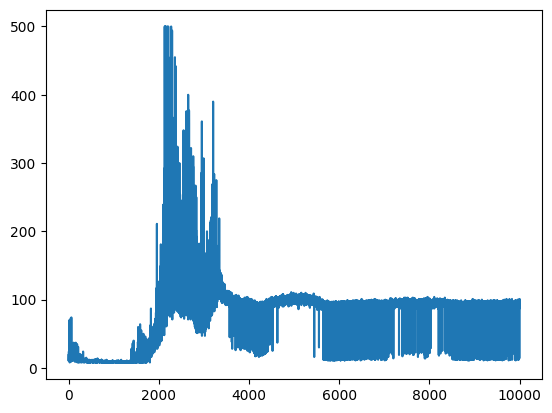

In [ ]:
plt.plot(np.arange(len(reward_arr)),reward_arr)

In [ ]:
torch.save(agent.qnetwork_local,'model_max.pth')

In [ ]:
N = 5
reward_max = []
for i in range(5):
  agent = TutorialAgent(state_size=state_shape,action_size = action_shape,seed = 0)
  reward_max.append(dqn())
  print(f'Completed {i+1} iterations')

Completed 1 iterations
Completed 2 iterations

Environment solved in 9098 episodes!	Average Score: 250.08
Completed 3 iterations

Environment solved in 3725 episodes!	Average Score: 250.29
Completed 4 iterations
Completed 5 iterations


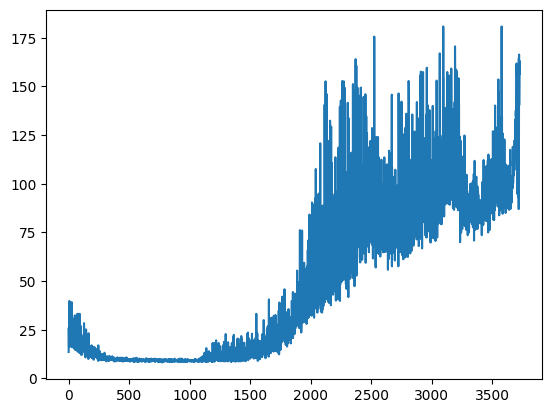

In [ ]:
min_size = min([len(i) for i in reward_max ])
max_reward = np.mean(np.array([i[:min_size] for i in reward_max]),axis = 0)
plt.plot(np.arange(len(max_reward)),max_reward)
plt.show()

In [ ]:
reward_save = [i[:min_size] for i in reward_max]
np.save("reward_CartPole_max.npy", reward_save)

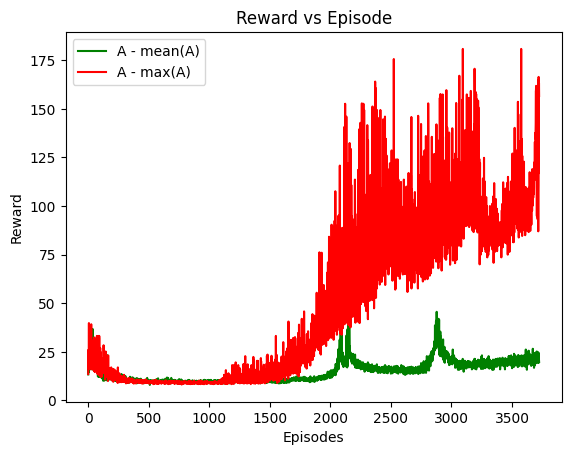

In [ ]:
avg_reward = np.load('reward_CartPole_mean.npy')
max_reward = np.load('reward_CartPole_max.npy')
avg_reward = np.mean(np.array([i[:min_size] for i in avg_reward]),axis = 0)
max_reward = np.mean(np.array([i[:min_size] for i in max_reward]),axis = 0)
plt.plot(np.arange(len(avg_reward)),avg_reward,c='g', label='A - mean(A)')
plt.plot(np.arange(len(max_reward)),max_reward,c='r', label='A - max(A)')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Reward vs Episode')
plt.legend()

#DQN

#mean(A)

In [ ]:
class TutorialAgent():

    def __init__(self, state_size, action_size, seed):

        ''' Agent Environment Interaction '''
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        ''' Q-Network '''
        self.qnetwork_local = QNetwork1(state_size, action_size, hl_size = 42).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        ''' Replay memory '''
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)


    def step(self, state, action, reward, next_state, done):

        ''' Save experience in replay memory '''
        self.memory.add(state, action, reward, next_state, done)

        ''' If enough samples are available in memory, get random subset and learn '''
        if len(self.memory) >= BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def act(self, state, eps=0.5):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            _,action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        ''' Epsilon-greedy action selection (Already Present) '''
        if random.random() > eps:
            return torch.argmax(action_values.to('cpu'),dim=1).item()
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """ +E EXPERIENCE REPLAY PRESENT """
        states, actions, rewards, next_states, dones = experiences
        ''' Get max predicted Q values (for next states) from target model'''
        V_targets_next, A_targets_next = self.qnetwork_local(next_states)
        # V_targets_next = V_targets_next.detach().max(1)[0].unsqueeze(1)
        # A_targets_next = A_targets_next.detach().max(1)[0].unsqueeze(1)
        # V_targets_next = V_targets_next.detach().unsqueeze(1)
        # A_targets_next = A_targets_next.detach().unsqueeze(1)
        # print(V_targets_next,A_targets_next)
        Q_targets_next = torch.add(V_targets_next, A_targets_next - A_targets_next.mean(dim=1, keepdim=True)).detach().max(1)[0].unsqueeze(1)

        ''' Compute Q targets for current states '''
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # print(Q_targets_next,Q_targets)
        # print(Q_targets_next.shape,Q_targets.shape)
        ''' Get expected Q values from local model '''
        V_targets, A_targets = self.qnetwork_local(states)
        # print(V_targets,A_targets)
        # V_targets = V_targets.detach().unsqueeze(1)
        # A_targets = A_targets.detach().unsqueeze(1)
        # print(states)
        # print(V_targets,A_targets)
        Q_expected = torch.add(V_targets, A_targets - A_targets.mean(dim=1, keepdim=True)).gather(1, actions)

        ''' Compute loss '''
        loss = F.mse_loss(Q_expected, Q_targets)

        ''' Minimize the loss '''
        self.optimizer.zero_grad()
        loss.backward()
        # if self.t_step == 0:
        #   print("Loss:- ",loss.item())
        ''' Gradiant Clipping '''
        """ +T TRUNCATION PRESENT """
        for param in self.qnetwork_local.parameters():
            param.grad.data.clamp_(-1, 1)

        self.optimizer.step()




In [ ]:
''' Defining DQN Algorithm '''

state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n


def dqn(n_episodes=10000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995,print_reward = False):

    scores_window = deque(maxlen=100)
    ''' last 100 scores for checking if the avg is more than 195 '''

    eps = eps_start
    ''' initialize epsilon '''
    total_reward = []
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break

        scores_window.append(score)
        total_reward.append(score)
        eps = max(eps_end, eps_decay*eps)
        ''' decrease epsilon '''

        # print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, score), end="")

        if i_episode % 100 == 0 and print_reward == True:
           print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=250.0:
           print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
           break
    return total_reward

''' Trial run to check if algorithm runs and saves the data '''

begin_time = datetime.datetime.now()

agent = TutorialAgent(state_size=state_shape,action_size = action_shape,seed = 0)
reward_arr = dqn(print_reward = True)

time_taken = datetime.datetime.now() - begin_time

print(time_taken)

Episode 100	Average Score: 16.28
Episode 200	Average Score: 11.91
Episode 300	Average Score: 11.40
Episode 400	Average Score: 10.23
Episode 500	Average Score: 9.84
Episode 600	Average Score: 9.51
Episode 700	Average Score: 9.83
Episode 800	Average Score: 9.58
Episode 900	Average Score: 9.50
Episode 1000	Average Score: 9.72
Episode 1100	Average Score: 9.83
Episode 1200	Average Score: 10.16
Episode 1300	Average Score: 10.64
Episode 1400	Average Score: 10.83
Episode 1500	Average Score: 9.46
Episode 1600	Average Score: 9.42
Episode 1700	Average Score: 14.07
Episode 1800	Average Score: 23.40
Episode 1900	Average Score: 30.74
Episode 2000	Average Score: 74.67
Episode 2100	Average Score: 36.22
Episode 2200	Average Score: 27.56
Episode 2300	Average Score: 26.67
Episode 2400	Average Score: 25.82
Episode 2500	Average Score: 25.32
Episode 2600	Average Score: 25.44
Episode 2700	Average Score: 24.69
Episode 2800	Average Score: 23.56
Episode 2900	Average Score: 25.45
Episode 3000	Average Score: 24.7

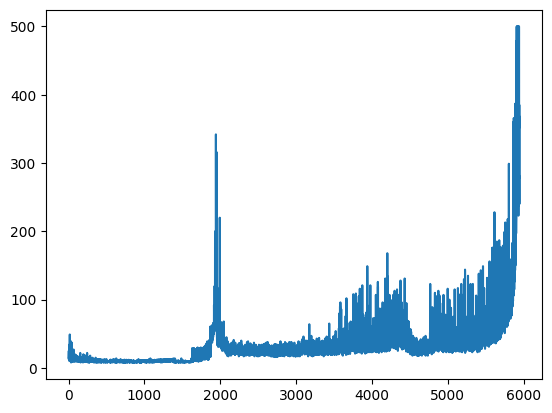

In [ ]:
plt.plot(np.arange(len(reward_arr)),reward_arr)

In [ ]:
torch.save(agent.qnetwork_local,'model_CartPole_mean_DQN.pth')

In [ ]:
N = 5
reward_avg = []
for i in range(5):
  agent = TutorialAgent(state_size=state_shape,action_size = action_shape,seed = 0)
  reward_avg.append(dqn())
  print(f'Completed {i+1} iterations')


Environment solved in 8739 episodes!	Average Score: 252.11
Completed 1 iterations

Environment solved in 6277 episodes!	Average Score: 250.25
Completed 2 iterations

Environment solved in 7337 episodes!	Average Score: 250.93
Completed 3 iterations

Environment solved in 5748 episodes!	Average Score: 252.71
Completed 4 iterations

Environment solved in 6108 episodes!	Average Score: 250.82
Completed 5 iterations


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


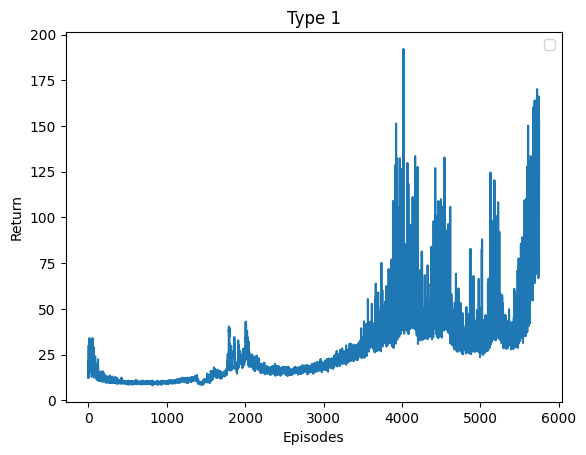

In [ ]:
# reward_avg = np.array(reward_avg)
min_size = min([len(i) for i in reward_avg ])
avg_reward = np.mean(np.array([i[:min_size] for i in reward_avg]),axis = 0)
plt.plot(np.arange(len(avg_reward)),avg_reward)
plt.xlabel('Episodes')
plt.ylabel('Return')
plt.title('Type 1')
plt.legend()

In [ ]:
reward_save = [i[:min_size] for i in reward_avg]
np.save("reward_CartPole_mean_DQN.npy", reward_save)

##max(A)

In [ ]:
class TutorialAgent():

    def __init__(self, state_size, action_size, seed):

        ''' Agent Environment Interaction '''
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        ''' Q-Network '''
        self.qnetwork_local = QNetwork1(state_size, action_size, hl_size = 42).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        ''' Replay memory '''
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

    def step(self, state, action, reward, next_state, done):

        ''' Save experience in replay memory '''
        self.memory.add(state, action, reward, next_state, done)

        ''' If enough samples are available in memory, get random subset and learn '''
        if len(self.memory) >= BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)


    def act(self, state, eps=0.5):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            _,action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        ''' Epsilon-greedy action selection (Already Present) '''
        if random.random() > eps:
            return torch.argmax(action_values,dim=1).item()
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """ +E EXPERIENCE REPLAY PRESENT """
        states, actions, rewards, next_states, dones = experiences
        ''' Get max predicted Q values (for next states) from target model'''
        V_targets_next, A_targets_next = self.qnetwork_local(next_states)
        # V_targets_next = V_targets_next.detach().max(1)[0].unsqueeze(1)
        # A_targets_next = A_targets_next.detach().max(1)[0].unsqueeze(1)
        # V_targets_next = V_targets_next.detach().unsqueeze(1)
        # A_targets_next = A_targets_next.detach().unsqueeze(1)
        Q_targets_next = torch.add(V_targets_next, A_targets_next - torch.max(A_targets_next, dim=1).values.unsqueeze(1)).detach().max(1)[0].unsqueeze(1)

        ''' Compute Q targets for current states '''
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # print(Q_targets_next,Q_targets)
        # print(Q_targets_next.shape,Q_targets.shape)
        ''' Get expected Q values from local model '''
        V_targets, A_targets = self.qnetwork_local(states)
        # print(V_targets,A_targets)
        # V_targets = V_targets.detach().unsqueeze(1)
        # A_targets = A_targets.detach().unsqueeze(1)
        # print(states)
        # print(V_targets,A_targets)
        Q_expected = torch.add(V_targets, A_targets - torch.max(A_targets, dim=1).values.unsqueeze(1)).gather(1, actions)

        ''' Compute loss '''
        loss = F.mse_loss(Q_expected, Q_targets)

        ''' Minimize the loss '''
        self.optimizer.zero_grad()
        loss.backward()
        # if self.t_step == 0:
        #   print("Loss:- ",loss.item())
        ''' Gradiant Clipping '''
        """ +T TRUNCATION PRESENT """
        for param in self.qnetwork_local.parameters():
            param.grad.data.clamp_(-1, 1)

        self.optimizer.step()




In [ ]:
''' Defining DQN Algorithm '''

state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n


def dqn(n_episodes=10000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995,print_reward = False):

    scores_window = deque(maxlen=100)
    ''' last 100 scores for checking if the avg is more than 195 '''
    total_reward = []
    eps = eps_start
    ''' initialize epsilon '''

    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        total_reward.append(score)
        scores_window.append(score)

        eps = max(eps_end, eps_decay*eps)
        ''' decrease epsilon '''

        # print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, score), end="")

        if i_episode % 100 == 0 and print_reward == True:
           print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=190:
           print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
           break
    return total_reward

''' Trial run to check if algorithm runs and saves the data '''

# begin_time = datetime.datetime.now()

# agent = TutorialAgent(state_size=state_shape,action_size = action_shape,seed = 0)
# reward_arr = dqn(print_reward = True)

# time_taken = datetime.datetime.now() - begin_time

# print(time_taken)

' Trial run to check if algorithm runs and saves the data '

In [ ]:
N = 5
reward_max = []
for i in range(5):
  agent = TutorialAgent(state_size=state_shape,action_size = action_shape,seed = 0)
  reward_max.append(dqn())
  print(f'Completed {i+1} iterations')


Environment solved in 2216 episodes!	Average Score: 192.98
Completed 1 iterations

Environment solved in 6581 episodes!	Average Score: 190.17
Completed 2 iterations
Completed 3 iterations

Environment solved in 7170 episodes!	Average Score: 193.10
Completed 4 iterations

Environment solved in 8820 episodes!	Average Score: 190.30
Completed 5 iterations


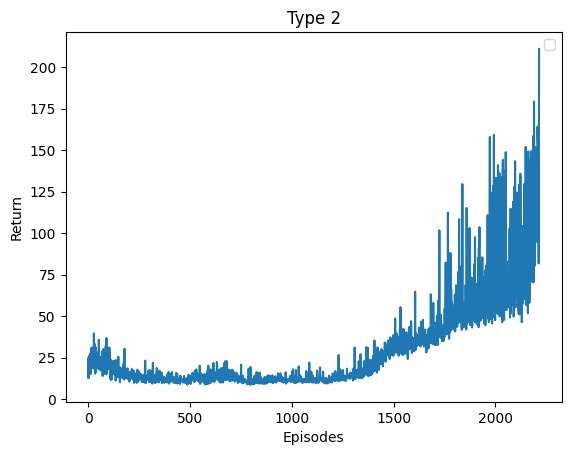

In [ ]:
min_size = min([len(i) for i in reward_max ])
max_reward = np.mean(np.array([i[:min_size] for i in reward_max]),axis = 0)
plt.plot(np.arange(len(max_reward)),max_reward)
plt.xlabel('Episodes')
plt.ylabel('Return')
plt.title('Type 2')
plt.legend()

In [ ]:
reward_save = [i[:min_size] for i in reward_max]
np.save("reward_CartPole_max_DQN.npy", reward_save)

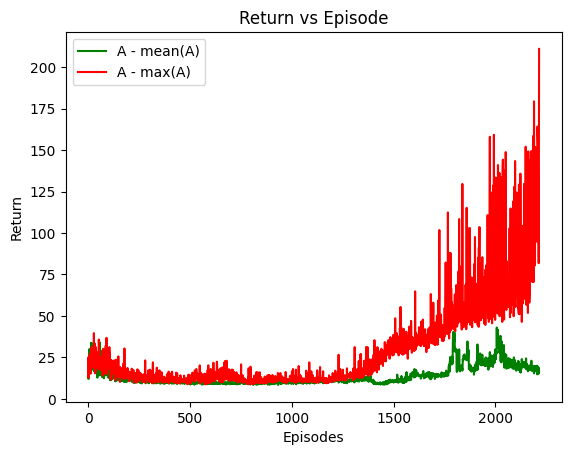

In [ ]:
avg_reward = np.load('reward_CartPole_mean_DQN.npy')
max_reward = np.load('reward_CartPole_max_DQN.npy')
min_size = min(min([len(i) for i in reward_max ]),min([len(i) for i in avg_reward ]))
avg_reward = np.mean(np.array([i[:min_size] for i in avg_reward]),axis = 0)
max_reward = np.mean(np.array([i[:min_size] for i in max_reward]),axis = 0)
plt.plot(np.arange(len(avg_reward)),avg_reward,c='g', label='A - mean(A)')
plt.plot(np.arange(len(max_reward)),max_reward,c='r', label='A - max(A)')
plt.xlabel('Episodes')
plt.ylabel('Return')
plt.title('Return vs Episode')
plt.legend()



In [ ]:
print(max(max_reward))
print(max(avg_reward))

211.0
43.0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
max_val = max(max(max_reward),max(avg_reward))
print(sum(max_val - max_reward)/len(max_reward))
print(sum(max_val - avg_reward)/len(avg_reward))

181.6657942238267
197.39386281588426


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
